In [190]:
import math

import scipy
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.stats import pearsonr
"""
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__
"""

'\nimport osmnx as ox\nox.config(log_console=True, use_cache=True)\nox.__version__\n'

In [2]:
def create_pdf_network():
    graph = nx.Graph()
    graph.add_edge(1, 4, weight=1)
    graph.add_edge(1, 2, weight=1)
    graph.add_edge(4, 2, weight=1)
    graph.add_edge(2, 3, weight=1)
    graph.add_edge(4, 3, weight=1)
    graph.add_edge(3, 6, weight=1)
    graph.add_edge(3, 7, weight=1)
    graph.add_edge(3, 5, weight=1)
    graph.add_edge(6, 7, weight=1)
    
    graph = graph.to_undirected()
    graph.remove_edges_from(graph.selfloop_edges())
    
    return graph



In [3]:
def visualize(G, big=False):
    if big:
        plt.figure(figsize=(12, 8))
    labels = G.nodes()
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, with_labels=True, nodecolor='r', edge_color='b', 
            node_size=500, font_size=16, pos=pos, width=6)   # default spring_layout
    new_labels = {(x,y): z["weight"] for x, y, z in graph.edges(data=True)}
    # use default edge labels
    nx.draw_networkx_edge_labels(G,pos, edge_labels=new_labels)
    plt.show(True)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q1

## a) Degree distribution,

In [4]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues, Pk

In [6]:
graph = create_pdf_network()

In [26]:
def plot_degree_dist(graph, use_log_scale=False, skip_plot=False):
    ks, Pk = degree_distribution(graph)
    if not skip_plot:
        fig = plt.subplot(1,1,1)
        if use_log_scale:
            fig.set_xscale('log')
            fig.set_yscale('log')

        plt.plot(ks,Pk,'bo')
        plt.xlabel("k", fontsize=20)
        plt.ylabel("P(k)", fontsize=20)
        plt.title("Degree distribution", fontsize=20)
        #plt.grid(True)
        plt.savefig('degree_dist.eps') #save the figure into a file
        plt.show(True)
    return ks, Pk

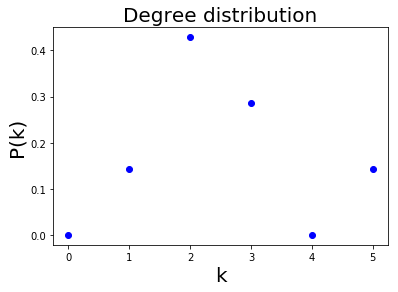

(array([0, 1, 2, 3, 4, 5]),
 array([0.        , 0.14285714, 0.42857143, 0.28571429, 0.        ,
        0.14285714]))

In [27]:
plot_degree_dist(graph)

## 1b) Local clustering coefficient

In [8]:
vcc = []
for i in graph.nodes():
    vcc.append(nx.clustering(graph, i))
vcc= np.array(vcc)
print('Clustering of all nodes:', vcc)

Clustering of all nodes: [1.         0.66666667 0.66666667 0.2        1.         1.
 0.        ]


## c) Transitivity

In [9]:
CC = (nx.transitivity(graph)) 
print("Transitivity = ","%3.4f"%CC)

Transitivity =  0.4737


## d) Distance matrix,

In [10]:
nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))

matrix([[0., 1., 2., 1., 3., 3., 3.],
        [1., 0., 1., 1., 2., 2., 2.],
        [2., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 2., 2., 2.],
        [3., 2., 1., 2., 0., 2., 2.],
        [3., 2., 1., 2., 2., 0., 1.],
        [3., 2., 1., 2., 2., 1., 0.]])

## e) Entropy of the degree distribution

In [11]:
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H



In [12]:
shannon_entropy(graph)

1.8423709931771088

## f) Second moment of the degree distribution.

In [13]:
def momment_of_degree_distribution2(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M


In [14]:
k2 = momment_of_degree_distribution2(graph, 2)
print("Second moment of the degree distribution = ", k2)

Second moment of the degree distribution =  8.0




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q2

In [15]:
def graph_to_undirected(graph, sum_edges=True, testing=False):   
    """Converts a graph to it's undirecte version. 
    If not sum_edges, we simply use the value of the 'last' edge when iterating.
    Otherwise, we sum the value of the incoming/outcoming edge.
    """
    if sum_edges:
        new_g = nx.Graph()
        new_g.add_edges_from(graph.edges, weight=0)
        for u, v in graph.edges:
            new_g[u][v]['weight'] += graph[u][v]['weight']
        new_g
    else:
        new_g = graph.to_undirected()

    # Quick test to show our implementation is correct
    if testing:
        graph = nx.DiGraph()
        graph.add_edge(2, 1, weight=1)
        graph.add_edge(1, 2, weight=2)
        print("Before:")
        visualize(graph)
        print("After:")
        visualize(graph_to_undirected(graph))
    
    return new_g

def graph_to_unweighted(graph, min_weight=1, testing=False):
    """Converts a graph to it's unweighted version. 
    Any edge with weight >= min_weight is included.
    """
    Gnew = nx.Graph()
    for (u,v,w) in graph.edges(data=True):
        if w['weight'] >= min_weight :
            Gnew.add_edge(u, v)
    
    if testing:
        graph = nx.Graph()
        graph.add_edge(1, 2, weight=1)
        graph.add_edge(2, 3, weight=2)
        graph.add_edge(3, 4, weight=3)
        print("Before:")
        visualize(graph)
        print("After:")
        visualize(graph_to_unweighted(graph, 3))

    return Gnew

    
def read_lesmis(filename, digraph=True):   
    """Reads the lesmis dataset"""
    # Read the directed network
    graph = nx.read_edgelist(filename, nodetype=int, data=(('weight',float),),
                            create_using=nx.DiGraph) 
    return graph

Weighted: 


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


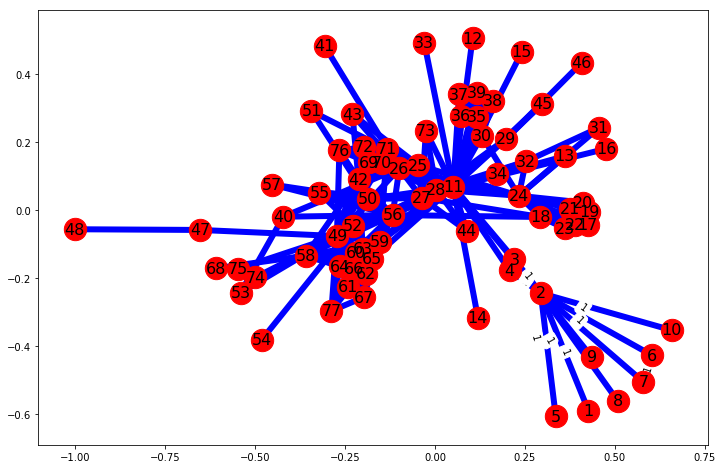

Unweighted: 


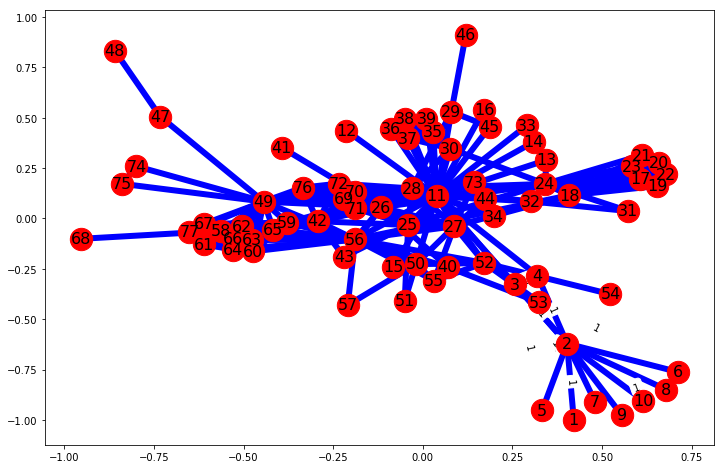

In [16]:
g_lesmis = read_lesmis("data/nets/lesmis.txt")
g_lesmis = graph_to_undirected(g_lesmis, sum_edges=True)
print("Weighted: ")
visualize(g_lesmis, big=True)
print("Unweighted: ")
visualize(graph_to_unweighted(g_lesmis), big=True)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q3

In [80]:
# Read the data
G = read_lesmis("data/nets/lesmis.txt")
G = graph_to_undirected(G, sum_edges=True)
G = graph_to_unweighted(G)

In [158]:
# let networkx return the adjacency matrix A
A = nx.adj_matrix(G)
A = A.todense()
A = np.array(A, dtype = np.float64)

# define walk length and starting idx
# we start with a random point
walk_length = 100*len(G.nodes)
repetitions=10
visited = np.zeros(len(G.nodes))

for i in range(repetitions):
    # Use this to start with the node with the highest amount of neighbours
    #current = A.sum(axis=0).argmax()
    current = np.random.randint(len(G.nodes))
    for _ in range(walk_length):
        # Get the list of possible nodes at current step
        possible_nodes = np.flatnonzero(A[current])
        # Go the next node
        next_node = np.random.choice(possible_nodes)
        visited[next_node] += 1
        #visited.append(next_node)
        current = next_node

In [159]:
visited

array([ 140., 1494.,  465.,  415.,  140.,  158.,  165.,  148.,  150.,
        137., 5519.,  137.,  306.,  151.,  158.,  162., 2248., 1583.,
       2374., 1673., 2655.,  666., 1279.,  556.,  175.,  322.,  989.,
        927.,  918.,  963.,  936.,  466.,  323., 3255., 1037., 1084.,
       2760., 2255., 1930., 1612., 1547., 1584., 1428.,  430.,  258.,
       1078., 1327., 1117., 1160., 1106., 1104., 1139., 1627.,  454.,
        315.,  463.,  151., 1151.,  633.,  151., 1628., 1622., 1326.,
       1600., 1897., 1713., 1760., 1460.,  316.,  306.,  991.,  278.,
        276.,  326.,  155.,  157.,  135.])

In [160]:
pearsonr(visited, A.sum(axis=0))

(0.9987035536721153, 9.329756823987865e-99)

Sim, está altamente correlacionado!



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q4

## a)

In [178]:
graph = create_pdf_network()

In [179]:
def power_transition_matrix(G, power):
    transition_matrix = nx.google_matrix(G, alpha=1)
    return transition_matrix**power

In [181]:
power_transition_matrix(graph, 1000)

matrix([[0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556],
        [0.11111111, 0.16666667, 0.16666667, 0.27777778, 0.11111111,
         0.11111111, 0.05555556]])

Ele converge!

## b)

$$ ((Aij)^3, Dij) $$ for i, j= 1, . . . , N

In [194]:
def create_scatter_plot(power_matrix, dists, plot=True):
    x = []
    y = []
    for i in range(len(graph.nodes)):
        for j in range(len(graph.nodes)):
            x.append(power_matrix[i, j])
            y.append(dists[i, j])
    if plot:
        sns.scatterplot(x, y)
        plt.show()
    return x, y

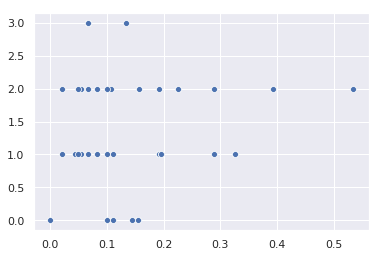

In [197]:
power_matrix = power_transition_matrix(graph, 3)
dists = nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))
create_scatter_plot(power_matrix, dists);

## c)

c) Verify how the Pearson correlation betweenDandPnvaries withn.  More specifically,construct a scatterplot forn= 1,2, ...and calculate the correlation for each case.  Then, plot thecorrelation in function ofn.

In [206]:
corrs = []
limit = 100

dists = nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))
for i in range(1, limit):
    power_matrix = power_transition_matrix(graph, i)
    x, y = create_scatter_plot(power_matrix, dists, plot=False);
    corrs.append(pearsonr(x, y)[0])

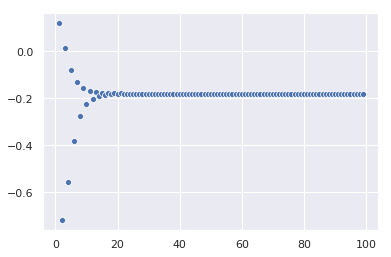

In [207]:
sns.scatterplot(list(range(1, limit)), corrs)

In [201]:
corrs

[(0.1206908424158188, 0.408774584819661),
 (-0.718176830999804, 6.279517877442194e-09),
 (0.013874712419211762, 0.9246164880823524),
 (-0.5541630630387857, 3.610673719365169e-05),
 (-0.08057513243578214, 0.5820713733476426),
 (-0.3797641146855711, 0.007115926049293611),
 (-0.13220654611911165, 0.36517997991043794),
 (-0.27549410379201095, 0.05537367696372381),
 (-0.15644375810975908, 0.2830636405159444),
 (-0.22452597627878418, 0.1209052270882958),
 (-0.1679214522780302, 0.24878009290079198),
 (-0.20059173189865895, 0.1669758604076678),
 (-0.1735756162120409, 0.23297025630050977),
 (-0.18937876182687688, 0.1924862900951344),
 (-0.17642890046743837, 0.22525972237080963),
 (-0.18410675701687376, 0.2053931256520581),
 (-0.17788152978789798, 0.22140274793527365),
 (-0.18161939790047935, 0.21168934143554385),
 (-0.17862154394819224, 0.21945559571489037),
 (-0.18044271139787274, 0.21471442444536296),
 (-0.17899745639244005, 0.21847105070887637),
 (-0.17988491318958277, 0.21615892369280654),




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q5



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q6



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q7



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q8



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q9



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q10